## Import library

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL as pil

from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
from tensorflow.keras import regularizers
import seaborn as sns

%matplotlib inline
import seaborn as sns
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base = "data/cancer/"

In [4]:
metadata= pd.read_csv(os.path.join(base,"HAM10000_metadata.csv"))

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


##### Data Visualization

In [6]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# Check weather meta data has null value or Not
metadata.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [8]:
# We can see age column has 57 null value
metadata.describe(include="all")

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0025163,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


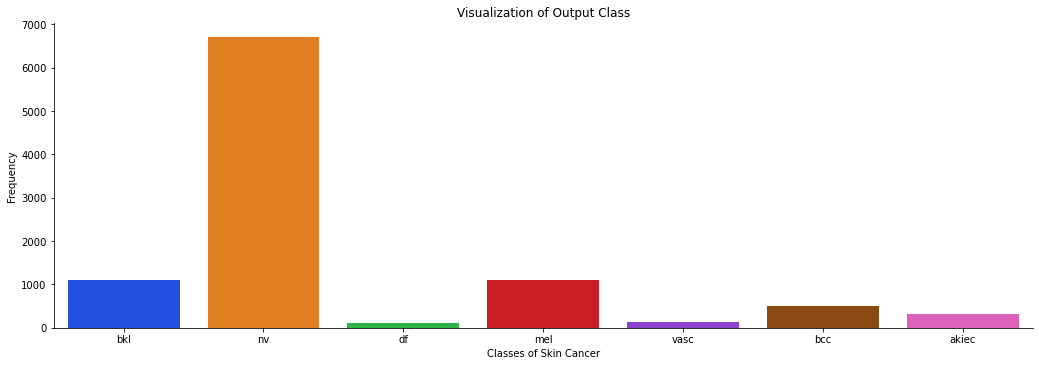

In [13]:
# We need to predict the  cancer type, Lets check the distribution of the values

g = sns.catplot(x = "dx", kind ="count", palette="bright" , data= metadata )
g.fig.set_size_inches(16,5)
g.ax.set_title("Visualization of Output Class")
g.set_xlabels("Classes of Skin Cancer")
g.set_ylabels("Frequency")

plt.show()

In [ ]:
# in this Figure the nv is too high , there is a class imbalance here with "nv" comprising more than 65%
# of the overall data , this will have an impact later during the classification but we need to overcome this


##### Skin cancer by Histopathology

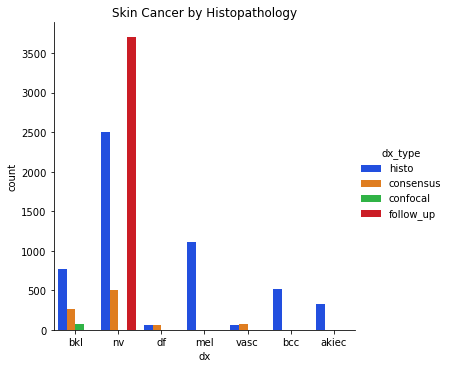

<Figure size 1152x576 with 0 Axes>

In [22]:
ax =sns.catplot(x = "dx", kind= "count", hue = "dx_type", palette= "bright", data= metadata)
plt.figure(figsize=[16,8])
ax.ax.set_title("Skin Cancer by Histopathology")
plt.show()

In [23]:
# It seems that all of "nv" are confirmed through follow-up, this behavior
# is not seen for other cancer class

###### Sking Cancer Localization (Occurance body localization)

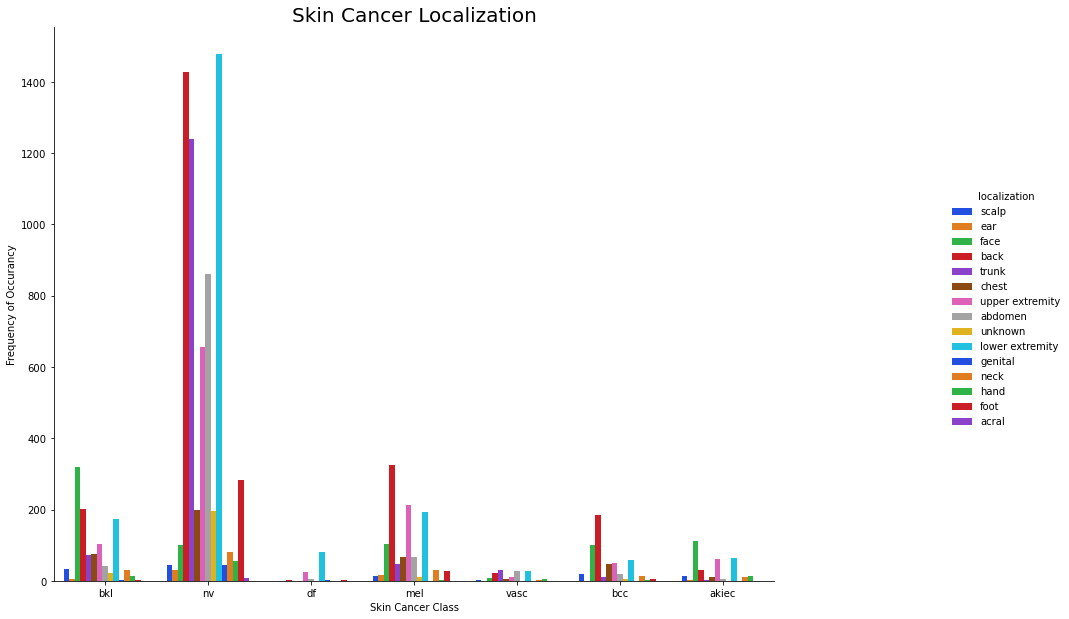

In [25]:
g = sns.catplot(x = "dx", kind= "count", hue = "localization", palette= "bright", data=metadata)
g.fig.set_size_inches(16,9)

g.ax.set_title("Skin Cancer Localization", fontsize = 20)
g.set_xlabels("Skin Cancer Class")
g.set_ylabels("Frequency of Occurancy")

In [26]:
# From the above , Skin Cancer seems to have more occurance in the back and lower extrimity of people
# may indicate over-exposure to the sun in water activities .This is another great insight we get by Data Analysis

##### Skin Cancer By Age

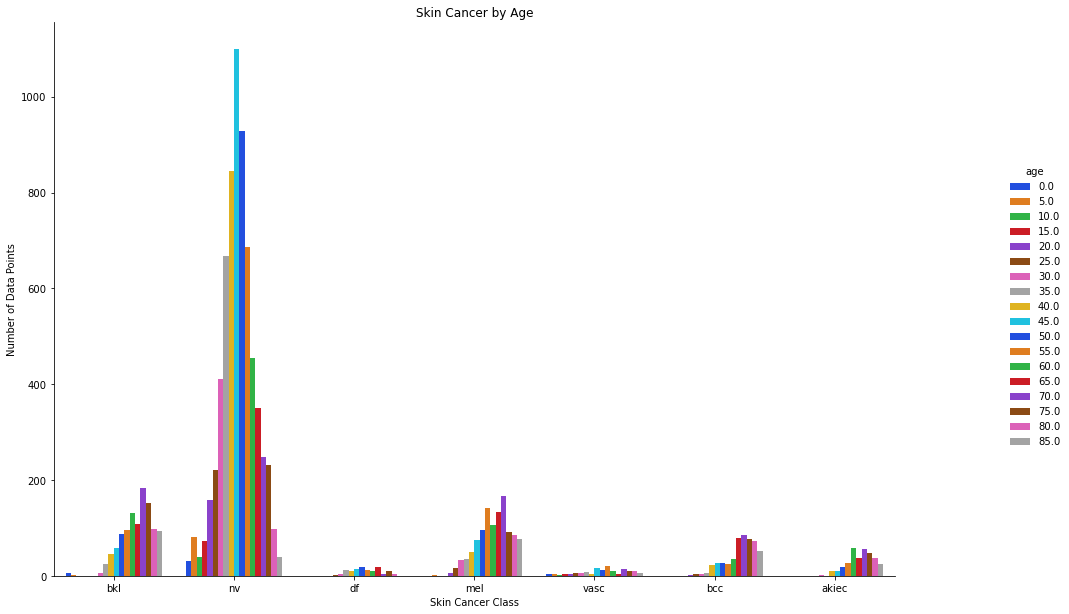

In [37]:
# Skin Cancer Occurance by Age
g = sns.catplot(x = "dx", kind = "count", hue = "age" , palette = "bright", data = metadata)
g.fig.set_size_inches(16,9)

g.ax.set_title("Skin Cancer by Age")
g.ax.set_xlabel("Skin Cancer Class")
g.ax.set_ylabel("Number of Data Points")
plt.show()

Another big insight we get here is regarding age group having Skin Cancers <br>
We get to know that "nv" is predominnant in people of age around 45 years old

##### Getting trainable from csv File

In [39]:
df = pd.read_csv(os.path.join(base, "hmnist_28_28_RGB.csv"))

In [40]:
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [41]:
# y is label column
y = df["label"]
x = df.drop("label", axis=1)

In [44]:
x.head()
# Since all data type is same so convert to Numpy array

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92


In [47]:
x = x.to_numpy()
x = x/255

In [55]:
x[1].shape

(2352,)

In [57]:
# Convert y to categorical
y = to_categorical(y)

In [59]:
y[0]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [62]:
df.label.nunique()

7

In [63]:
# Since there are 7 classes only, We can label them manually
label = {
    "Actinic Keratoses":0,
    "Basal cell carcinoma":1,
    "Benign keratosis-like lesions":2,
    "Dermatofibroma":3,
    "Melanocytic nevi":4,
    "Melanoma":6,
    "Vascular lessions":5
}

#### Images

In [67]:
x.shape

(10015, 2352)

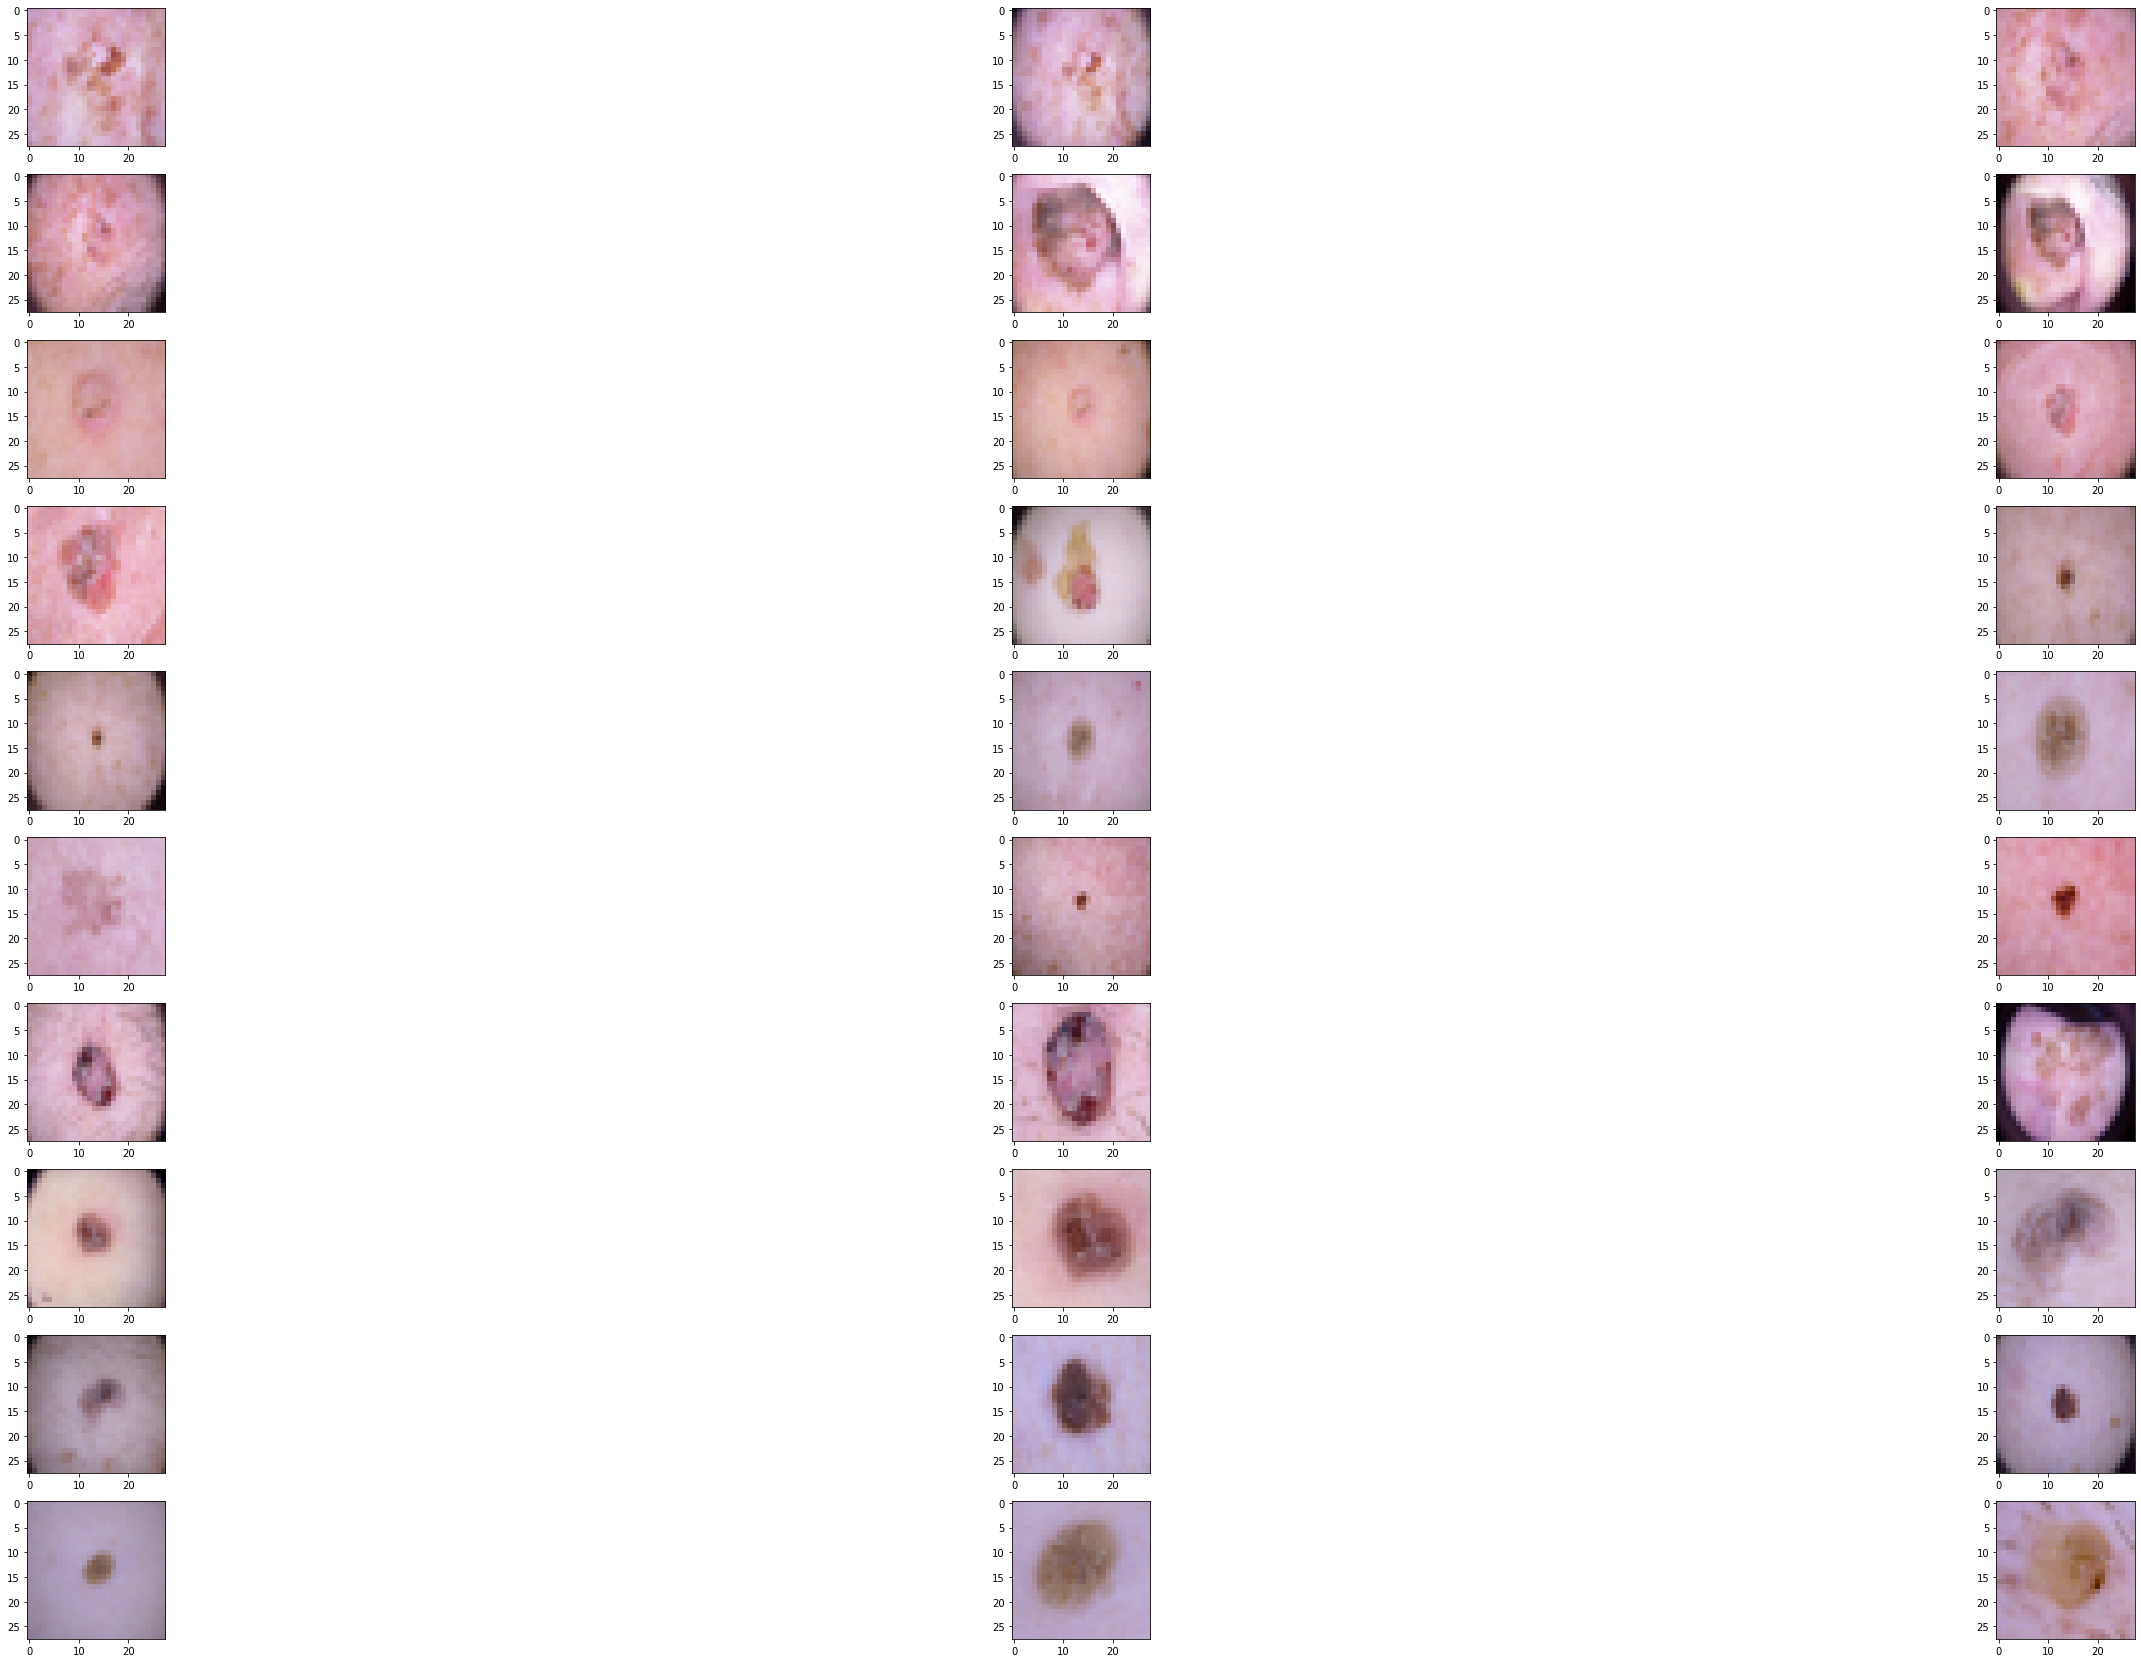

In [69]:
# Since the above shape cant be plotted so we need to change the shape to 28x28,
x = x.reshape(-1,28,28,3)
plt.figure(figsize = (50,30))
for i in range(30):
    plt.subplot(10,3,i+1)
    img= x[i]
    plt.imshow(img)

##### Apply machine Learnign

In [70]:
# Spliting of DataSet
x_train, y_train, x_test, y_test = train_test_split(x,y, test_size = 0.02, random_state = 42)

##### Image Augmentation to expand Train data